# EdgeCameras.jl: Edge Cameras in Julia

This project consists of an implementation of *edge cameras* based on the work of Bouman et al. [1]. An edge camera is formed when a sharp edge (such as the corner of a wall) creates a natural one-dimensonal pinhole camera, revealing the motions of objects which are completely obscured by the corner. More information from the original authors can be found at [people.csail.mit.edu](https://people.csail.mit.edu/klbouman/cornercameras.html). 

This package consists of an entirely new implementation of the edge camera algorithm, based on the work presented in the paper, and done entirely in [Julia](https://julialang.org/) (except for the raw video I/O, which is ultimately handled by `ffmpeg`).

[1] Katherine L. Bouman, Vickie Ye, Gregory W. Wornell, Adam B. Yedidia, Antonio Torralba, William T. Freeman, and Frédo Durand. "Turning Corners into Cameras: Principles and Methods". ICCV 2017.

# Installation

In Julia:


```julia
using Pkg
pkg"add https://github.com/rdeits/EdgeCameras.jl"
```


# Stereo Reconstruction

We can use two edge cameras (such as two of the edges around a doorway) to obtain two bearings to a moving object. This lets us, at least approximately, track the 2D position of the object on the other side of the doorway. 

In [1]:
# Optional:
#
# Tell Julia to use the package environment
# contained in the EdgeCameras.jl repository. 
# This will give you exactly the same set of 
# Julia packages that were used to make this 
# demo. 
using Pkg
pkg"activate .."
pkg"instantiate"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `git@github.com:JuliaRegistries/General.git`


In [ ]:
using Plots: plot
using StaticArrays: SVector
using VideoIO: openvideo
using EdgeCameras: StaticSource, VideoStatistics, Params, EdgeCamera, reconstruct
using Images: imadjustintensity, RGB
using Unitful
using AxisArrays
using Interpolations

In [2]:
# Open a video file. This assumes that you've already downloaded the 
# example videos data from https://people.csail.mit.edu/klbouman/cornercameras.html
video = openvideo("../../example_videos/stereo/red_person_walking_circles.MP4")

VideoReader(...)

INFO: Recompiling stale cache file /Users/rdeits/.julia/lib/v0.6/QuartzImageIO.ji for module QuartzImageIO.


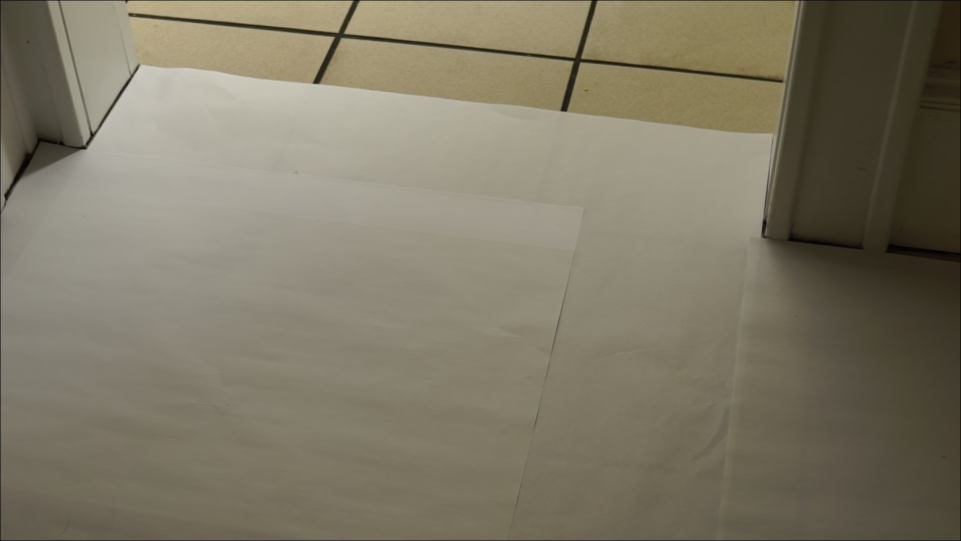

In [3]:
# Extract the background and variance over several frames. This call
# takes the mean and variance over frames from 1 second to 20 seconds, 
# sampling 6 frames per second:
stats = VideoStatistics(video, (1u"s", 20u"s"), 6/u"s")

# the `u"s"` is a shorthand for the `Seconds` type from Unitful.jl

In [4]:
# Pre-specify some parameters
time_range = (0u"s", 30u"s") # the time span over which to reconstruct video
reconstruction_framerate = 10/u"s" # the frame rate for reconstruction

10 s^-1

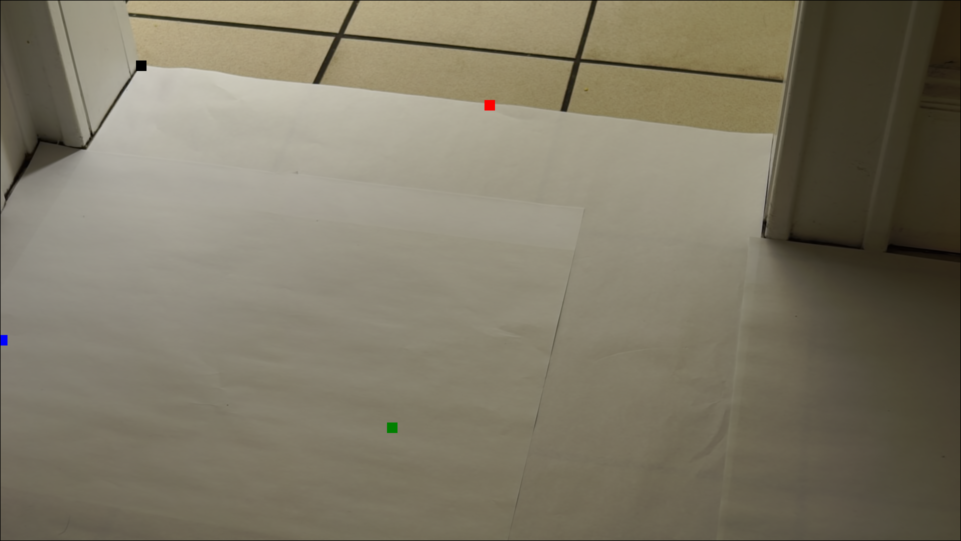

In [5]:
# Specify the corners of a square region around the edge of the wall you're 
# using as a camera. These are pixel coordinates, with the first point (black) 
# at the location of the bottom corner of the wall, and the remaining points
# arranged in the order shown by the red, green, and blue points
corners1 = [[131, 282], 
    [210, 979],
    [855, 784], 
    [680, 4], 
]
source1 = StaticSource(video, corners1, stats)

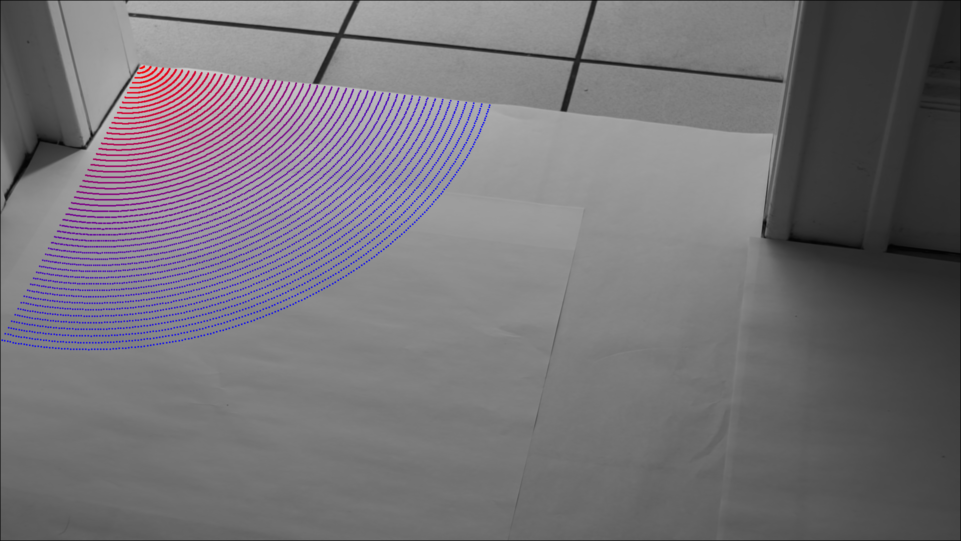

In [6]:
# cam1 corresponds to one of the edges on the left:
cam1 = EdgeCamera(source1)

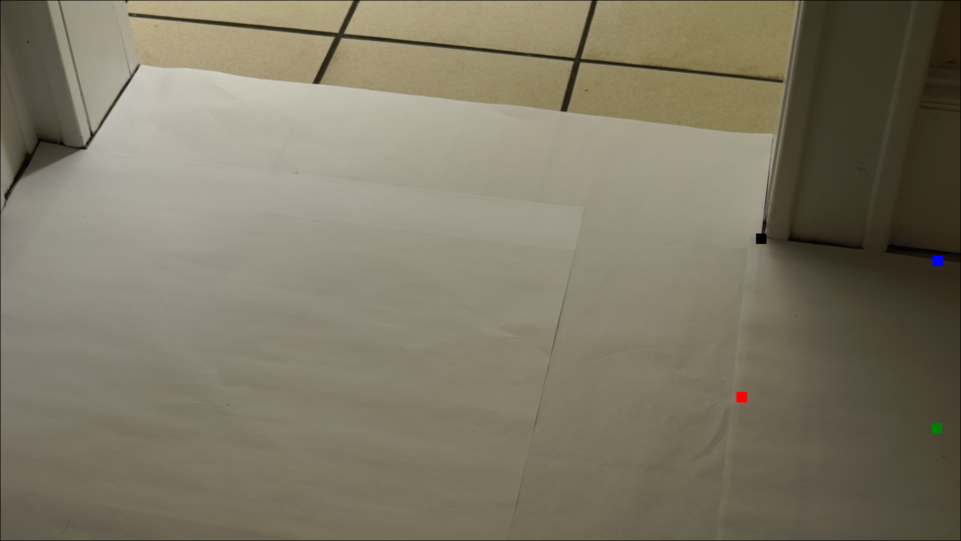

In [7]:
# Now specify the corders of the second edge camera, this one on the 
# right side of the doorway:
corners2 = [
    [477, 1522],
    [794, 1483],
    [856, 1873],
    [521, 1875]
]
source2 = StaticSource(video, corners2, stats)

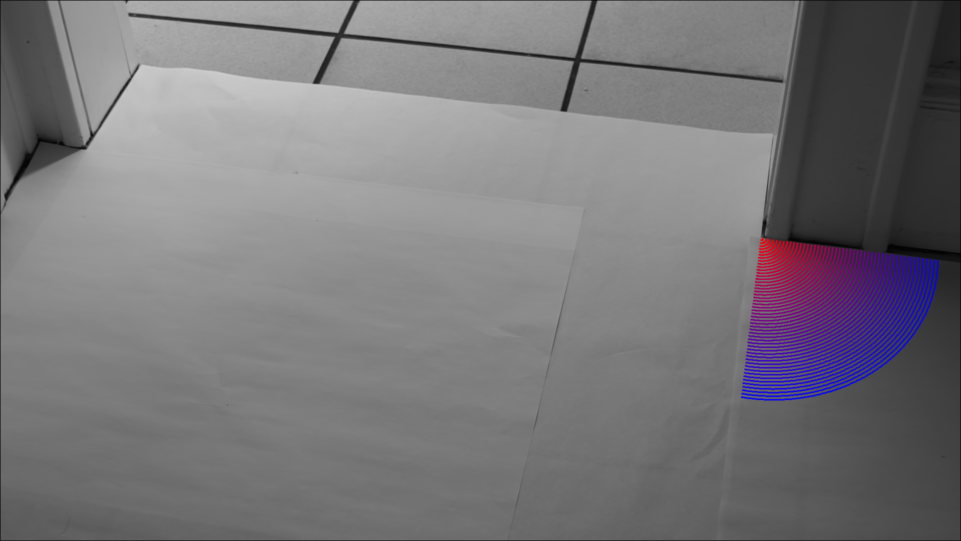

In [8]:
# Show where cam2 will draw samples
cam2 = EdgeCamera(source2)

In [9]:
# Now we will reconstruct the 1D video seen by each camera:

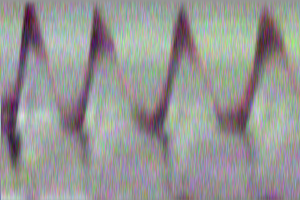

In [10]:
# Left side
trace1 = reconstruct(cam1, time_range, reconstruction_framerate)
imadjustintensity(trace1)

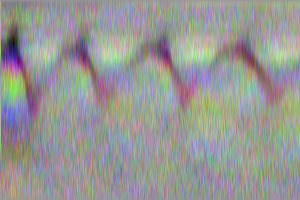

In [11]:
# Right side
trace2 = reconstruct(cam2, time_range, reconstruction_framerate)
imadjustintensity(trace2)

## Extracting 2D Position

To estimate the position of the person on the other side of the door, we need to first identify the center of the 1D video signal. Rather than writing code to do it automatically, we can just indicate a few points by hand and interpolate linearly:

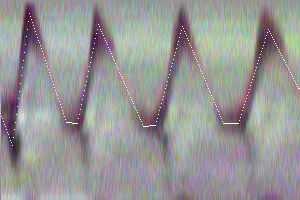

In [12]:
path1 = [
    [114, 1],
    [146, 13],
    [14, 30],
    [123, 67],
    [124, 78],
    [25, 99],
    [127, 144],
    [126, 156],
    [27, 183],
    [124, 224],
    [124, 239],
    [30, 269],
    [89, 299]
    ]

path1 = extrapolate(interpolate(
    (last.(path1),),
    first.(path1),
        Gridded(Linear())),
    Flat()
    );

# Show the extracted path on top of the trace
im = imadjustintensity(trace1)
for i in 1:size(trace1, 2)
    im[round(Int, path1[i]), i] = RGB(1., 1, 1)
end
im

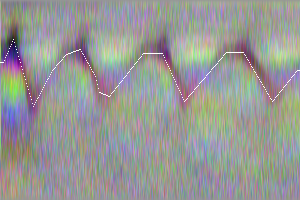

In [13]:
path2 = [
    [63, 4],
    [40, 14],
    [107, 34],
    [71, 53],
    [55, 67],
    [50, 81],
    [77, 96],
    [93, 100],
    [97, 110],
    [54, 144],
    [54, 163],
    [102, 185],
    [53, 227],
    [53, 244],
    [102, 273],
    [71, 298]
    ]

path2 = extrapolate(interpolate(
    (last.(path2),),
    first.(path2),
        Gridded(Linear())),
    Flat()
    );


im = imadjustintensity(trace2)
for i in 1:size(trace2, 2)
    im[round(Int, path2[i]), i] = RGB(1., 1., 1.)
end
im

In [14]:
# From the two angles extracted from the left and right
# cameras, we can estimate the position of the object
# in 2D space:
B = 1.0
positions = map(1:size(trace1, 2)) do i
    θ1 = π/2 * path1[i] / size(trace1, 1) - π/2
    θ2 = π/2 * path2[i] / size(trace2, 1)
    Pz = B / (cot(θ1) + cot(θ2))
    Px = Pz * cot(θ1)
    SVector(Px, Pz)
end;

In [15]:
plt = plot(first.(positions), 
           last.(positions), 
           linewidth=3, 
           color=1:length(positions),
           legend=false,
           xlabel="X-position",
           ylabel="Z-position",
           title="Inferred Position over Time (Scene B)")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 
 
 -2.5 
 
 
 -2.0 
 
 
 -1.5 
 
 
 -1.0 
 
 
 -0.5 
 
 
 1.0 
 
 
 1.2 
 
 
 1.4 
 
 
 1.6 
 
 
 1.8 
 
 
 2.0 
 
 
 2.2 
 
 
 Inferred Position over Time (Scene B) 
 
 
 X-position 
 
 
 Z-position 
 
<polyline clip-path="url(#clip9402)" style="stroke:#000003; stroke-width:3; stroke-opacity:1; fill:none" points="
 258.298,176.384 207.758,140.666 142.107,94.2684 53.2869,31.4961 50.6562,51.2084 48.8692,71.2254 47.9701,91.5206 48.0064,112.066 49.0293,132.832 51.0942,153.786 
 54.2619,174.895 58.5986,196.122 64.1777,217.429 333.484,350.446 368.015,349.937 394.42,347.732 415.888,344.64 434.17,341.115 450.305,337.438 464.945,333.794 
 478.514,330.311 491.301,327.083 503.504,324.18 515.261,321.657 526.672,319.557 537.805,317.916 548.709,316.762 559.415,316.118 569.947,316.003 580.315,316.432 
 574.476,297.379 567.592,275.558 559.401,250.251 549.543,220.474 543.986,221.807 538.457,223.35 532.963,225.104 527.508,227.067 522.099,229.241 516.74,231.623 
 511.439,234.213 506.199,237.01 501.028,240.013 495.931,243.22 490.914,246.629 485.983,250.239 481.144,254.047 476.404,258.052 471.769,262.251 467.245,266.641 
 462.839,271.22 458.559,275.984 454.41,280.931 446.584,279.686 438.342,278.312 429.629,276.783 420.379,275.069 410.513,273.135 399.937,270.938 388.536,268.428 
 376.171,265.542 362.67,262.204 347.817,258.318 331.342,253.765 312.895,248.39 292.023,241.995 268.121,234.313 273.862,239.958 279.471,245.468 284.953,250.849 
 290.314,256.104 295.557,261.238 300.685,266.255 305.704,271.159 310.616,275.953 315.425,280.642 320.135,285.228 324.748,289.715 377.758,320.833 415.567,343.175 
 443.934,360.065 453.96,358.748 463.208,357.331 471.828,355.859 479.939,354.367 487.631,352.883 494.977,351.431 502.035,350.028 508.85,348.693 515.462,347.437 
 521.9,346.274 528.19,345.212 534.352,344.263 540.404,343.432 546.36,342.727 552.231,342.155 556.137,332.793 560.565,323.853 565.487,315.377 558.698,293.118 
 553.984,286.03 548.947,278.477 543.55,270.41 537.75,261.768 531.5,252.482 524.742,242.471 517.41,231.642 509.424,219.882 500.69,207.058 491.096,193.01 
 485.647,193.044 480.137,193.145 474.564,193.312 468.925,193.542 463.215,193.834 457.431,194.187 451.568,194.598 445.623,195.065 439.588,195.585 433.459,196.157 
 427.229,196.776 420.889,197.44 414.432,198.145 407.848,198.887 401.127,199.662 394.256,200.466 387.223,201.292 380.012,202.136 372.607,202.991 364.988,203.85 
 357.133,204.705 349.019,205.547 340.617,206.367 331.895,207.152 322.816,207.89 313.337,208.566 303.41,209.165 292.976,209.665 281.969,210.045 270.31,210.279 
 257.905,210.336 244.642,210.179 230.386,209.765 214.976,209.041 216.8,210.12 218.609,211.189 220.402,212.25 222.18,213.301 223.942,214.343 225.69,215.377 
 227.423,216.402 229.141,217.418 230.845,218.426 232.534,219.425 234.21,220.416 235.872,221.399 297.5,257.845 342.755,284.609 377.447,305.126 404.93,321.38 
 427.272,334.593 445.821,345.562 461.49,354.83 464.601,348.527 467.946,342.413 471.511,336.494 475.283,330.778 479.251,325.27 483.404,319.976 487.73,314.901 
 492.22,310.051 496.863,305.429 501.65,301.042 506.571,296.893 511.617,292.985 516.779,289.322 522.048,285.908 527.415,282.745 532.872,279.836 538.41,277.183 
 544.021,274.788 549.696,272.652 555.428,270.777 548.17,252.136 539.847,231.075 535.083,230.246 530.258,229.465 525.368,228.731 520.411,228.043 515.384,227.398 
 510.284,226.795 505.107,226.231 499.849,225.706 494.505,225.215 489.069,224.758 483.537,224.33 477.903,223.929 472.158,223.551 466.295,223.193 460.306,222.851 
 454.181,222.519 447.91,222.194 441.479,221.868 434.877,221.538 428.087,221.194 421.094,220.831 413.877,220.439 406.415,220.01 398.684,219.532 390.656,218.994 
 382.299,218.382 373.576,217.68 364.447,216.872 354.861,215.936 344.764,214.849 334.088,213.585 322.758,212.112 310.682,210.392 297.751,208.381 283.836,206.026 
 268.778,203.264 252.386,200.017